## Data Preprocessing

### Code to test the data loader (tokenizer from the next part is included in the data loder .py file)

In [1]:
from torch.utils.data import DataLoader
from dataset.audio_dataset import get_data_loader

from hparams import Hparams

train_loader = get_data_loader(split='train', args=Hparams.args)

for batch in train_loader:
    waveforms = batch["waveform"]          # shape: [batch, channels, samples]
    sample_rates = batch["sample_rate"]   
    metadata = batch["metadata"]     
        
    padded_prompt = batch["padded_prompt"]  
    padded_response = batch["padded_response"]  

    break

Dataset source: /Users/reiner/Documents/GitHub/cadenza_2026_submission/project/dataset/cadenza_data/metadata/train_metadata.json


/Users/reiner/Documents/GitHub/cadenza_2026_submission/project/dataset/audio_dataset.py:162: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  torchaudio.set_audio_backend("soundfile")
/Users/reiner/Documents/GitHub/cadenza_2026_submission/venv/lib/python3.12/site-packages/torchaudio/_internal/module_utils.py:71: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  return func(*args, **kwargs)
/Users/reiner/Documents/GitHub/cadenza_2026_submission/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarni

### Check the result shape returned by the dataloader

In [2]:
# To check dataset
print("Waveforms shape           :", waveforms.shape)
print("sr shape of every item    :", sample_rates)
print("tokenized prompt shape    :", padded_prompt.shape)
print("tokenized response shape  :", padded_response.shape)

Waveforms shape           : torch.Size([8, 267648])
sr shape of every item    : [44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100]
tokenized prompt shape    : torch.Size([8, 62])
tokenized response shape  : torch.Size([8, 62])


Check the first entry on the returned batch

In [3]:
import json
from utils.utils import dump_json

print("First metadata entry:", metadata)

dataset = train_loader.dataset
waveform_dict = dataset[0]  # first sample

waveform = waveform_dict["waveform"]

print('\nfrom train_loader.dataset')
print(waveform_dict["waveform"].shape)
print(waveform_dict['sample_rate'])

# print(waveform_dict["metadata"])


print(dump_json(waveform_dict["metadata"]))


First metadata entry: [{'signal': 'c221f2084c780e8f212f4697', 'fma': '147301', 'original_prompt': 'cos you better hold on', 'prompt': 'cos you better hold on', 'original_response': '#', 'response': '', 'n_words': 5, 'words_correct': 0, 'correctness': 0.0, 'hearing_loss': 'Moderate', 'tokenized_prompt': [3, 15, 19, 27, 25, 15, 21, 27, 2, 5, 20, 20, 5, 18, 27, 8, 15, 12, 4, 27, 15, 14], 'tokenized_response': []}, {'signal': '63de05fbfcab2d7748b83cb3', 'fma': '000649', 'original_prompt': 'And then lower it down again', 'prompt': 'and then lower it down again', 'original_response': "I don't know where it's all the same", 'response': 'i do not know where it is all the same', 'n_words': 6, 'words_correct': 1, 'correctness': 0.1666666667, 'hearing_loss': 'Mild', 'tokenized_prompt': [1, 14, 4, 27, 20, 8, 5, 14, 27, 12, 15, 23, 5, 18, 27, 9, 20, 27, 4, 15, 23, 14, 27, 1, 7, 1, 9, 14], 'tokenized_response': [9, 27, 4, 15, 27, 14, 15, 20, 27, 11, 14, 15, 23, 27, 23, 8, 5, 18, 5, 27, 9, 20, 27, 9,

## From Video

In [4]:
data = next(iter(dataset))

# Print the waveform
waveform = data["waveform"].squeeze(0)
print(f"Waveform: {waveform}")
print(f"Waveform shape: {tuple(waveform.shape)}")

# Print the sampling rate
sr = data["sample_rate"]
print(f"Sampling Rate: {sr}")

# Print the transcription from the metadata
transcription = data["metadata"]["prompt"]
print(f"Waveform: {transcription}")

filename = data["metadata"]["signal"]
print(f"Filename: {filename}.flac")

# Print the audio length
length = waveform.size(0) / sr
print(f"Audio length: {length}")

Waveform: tensor([0., 0., 0.,  ..., 0., 0., 0.])
Waveform shape: (159744,)
Sampling Rate: 44100
Waveform: cos you better hold on
Filename: c221f2084c780e8f212f4697.flac
Audio length: 3.622312925170068


In [5]:
from IPython.display import Audio
Audio(waveform, rate=sr)

/var/folders/9_/fy5p9d_52f9d3dxp8df05zlc0000gn/T/ipykernel_15662/581510660.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


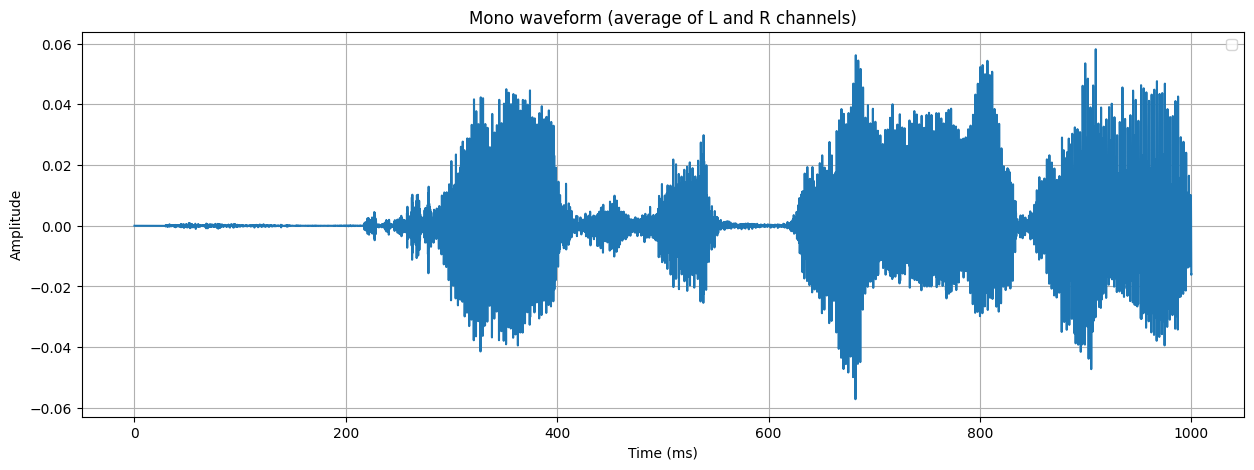

In [20]:
import matplotlib.pyplot as plt
import numpy as np

start_ms = 0
end_ms = 1000

start_idx = int(start_ms * sr / 1000)
end_idx = int(end_ms * sr / 1000)

waveform_np = waveform[start_idx:end_idx].numpy()

# Create time axis in miliseconds
time_ms = np.arange(waveform_np.shape[0]) * (1000 / sr)

plt.figure(figsize=(15, 5))
plt.plot(time_ms, waveform_np, alpha=1)
# plt.plot(time_ms, waveform_np[1], label='Right Channel', alpha=0.75)
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.title('Mono waveform (average of L and R channels)')
plt.legend()
plt.grid()
plt.show()

In [21]:
print(waveform.shape)

torch.Size([159744])


### Estimate the duration to load the whole train dataset

In [22]:
# Estimate to load the whole training set
from tqdm import tqdm
from dataset.audio_dataset import move_data_to_device
import time

t0 = time.time()
for i, data in enumerate(tqdm(train_loader)):
    dict = move_data_to_device(data, 'cpu')

    print(data['waveform'].shape)

    # print(f'i={i}')
    # assert list(x.shape) == [8, 250, 256]  # shape in [B, T, D], i.e., [Batch size, num of frame per sample, feature dimention]
    # assert list(onset.shape) == list(offset.shape) == list(octave.shape) == list(pitch_class.shape) == [8, 250]
    if i == 4:
        dur = time.time()-t0
        est_time = dur / 5 * 1101
        break

print('\n5 batches use {:.2f} seconds'.format(dur))
print('Estimated time to load the whole training set: {:.2f} seconds.'.format(est_time))

  0%|          | 0/1101 [00:00<?, ?it/s]/Users/reiner/Documents/GitHub/cadenza_2026_submission/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/reiner/Documents/GitHub/cadenza_2026_submission/venv/lib/python3.12/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
  0%|          | 4/1101 [00:00<00:53, 20.34it/s]

torch.Size([8, 267648])
torch.Size([8, 321984])
torch.Size([8, 276800])
torch.Size([8, 372565])
torch.Size([8, 453440])

5 batches use 0.21 seconds
Estimated time to load the whole training set: 46.38 seconds.


For text-to-speech character level, we'll have 29 characters in the vocabulary:
* 26 Characters (A-Z)
* The blank token (to mark the end of sentence)
* A space token (for word boundaries)
* Apostrophe Token (' for words that have 's or 're)

In [10]:
from dataset.audio_dataset import get_tokenizer

tokenizer = get_tokenizer(save_path='dataset/tokenizer.json')

# tokenizer.get_vocab()
sorted(tokenizer.get_vocab().items(), key=lambda x: x[1])

[('□', 0),
 ('a', 1),
 ('b', 2),
 ('c', 3),
 ('d', 4),
 ('e', 5),
 ('f', 6),
 ('g', 7),
 ('h', 8),
 ('i', 9),
 ('j', 10),
 ('k', 11),
 ('l', 12),
 ('m', 13),
 ('n', 14),
 ('o', 15),
 ('p', 16),
 ('q', 17),
 ('r', 18),
 ('s', 19),
 ('t', 20),
 ('u', 21),
 ('v', 22),
 ('w', 23),
 ('x', 24),
 ('y', 25),
 ('z', 26),
 (' ', 27),
 ("'", 28)]

### Code to test the tokenizer

In [ ]:
# data = next(iter(dataset))
data = dataset[1]

# Print the transcription from the metadata
transcription_ori = data["metadata"]["original_prompt"]
transcription = data["metadata"]["prompt"]

print(f"Original prompt          : {transcription_ori}")
print(f"Processed prompt         : {transcription}")

response_ori = data["metadata"]["original_response"]
response = data["metadata"]["response"]
print(f"\nOriginal response        : {response_ori}")
print(f"Processed response       : {response}")

# Encode the prompt
# transcription = transcription.upper()
input_ids = tokenizer.encode(transcription)
response_ids = tokenizer.encode(response)

# print(f'Input Text (uppercase)              : {transcription}')
print(f'\nTokenized Input          : {input_ids.ids}')
print(f'Tokenized Response       : {response_ids.ids}')

Original prompt          : And then lower it down again
Processed prompt         : and then lower it down again

Original response        : I don't know where it's all the same
Processed response       : i do not know where it is all the same


NameError: name 'tokenizer' is not defined

## MFCCs, and Encode-Decoder Networks

To train a speech-to-text we are not going to train encoder-decoder architecture like transformer. We will train 1 model only that is pure self-attention based model

### Architecture

Audio Input -> Conv Layer -> Self Attention -> RVQ -> Text Predictor

Output on each layer:
* Conv Layer : The convolutional layer downsamples and extracts features from input waveform, producing *Downsamples Audio Embeddings*.
* Self Attention : The transformer module contextualizes each section of the adio with the entire speech, producing *Contextual Audio Embeddings*.
* RVQ : The RVQ module compresses and quantizes the audio into discrete bins, producing *Quantized Audio Embeddings*.
* Text Predictor : Text predictor generates text from the embeddings, producing the *transcription*.

### Embeddings

In [ ]:
import torch.nn as nn
import torch

num_embeddings = 10
embedding_dim = 32

embedding = nn.Embedding(num_embeddings, embedding_dim)

In [ ]:
embedding.weight.shape

torch.Size([10, 32])

In [ ]:
print("Embedding first 5 value per row")
print("-" * 50)

for i in range(num_embeddings):
    values = embedding.weight[i][:5].detach()       # Show only first value
    print(f'{i:^7d} | {values.numpy()}')

Embedding first 5 value per row
--------------------------------------------------
   0    | [ 1.4623965   1.1992903  -1.1271235   2.44867    -0.74926656]
   1    | [-1.6003047  -1.3980161   0.470531   -1.5641216   0.13861668]
   2    | [ 0.90889084  0.89088756 -1.8776032  -2.1952026  -0.22578081]
   3    | [-0.49544826  0.16921908 -1.1214402   1.3246051  -0.23618394]
   4    | [ 1.7144105  -0.84213525 -0.63446337 -0.16988398  1.9304075 ]
   5    | [-0.32136878 -1.2856764  -1.3329488   0.5060622   0.6809592 ]
   6    | [ 0.2954602  -1.3090768  -0.47097713 -1.7841697  -0.5373543 ]
   7    | [ 0.6103318  -0.0130927   0.56325734 -0.19460668 -0.34950683]
   8    | [ 0.15083484  0.45110634  1.5514604  -0.68494546 -1.8610084 ]
   9    | [ 1.2075127  -0.63015974 -0.71106035  0.31948623 -0.3460174 ]


In [ ]:
# embedding.weight[0]
embedding(torch.tensor([0, 2, 3]))

tensor([[ 1.4624,  1.1993, -1.1271,  2.4487, -0.7493,  0.4246,  1.0842, -0.0875,
          1.1734,  1.5030,  0.2234,  1.0995,  0.4874,  0.5155,  0.4264,  0.1759,
          1.4425, -1.2612, -0.0872, -2.4040, -0.7378,  0.3900,  0.3197, -1.4647,
          0.3481, -0.4084,  0.2483,  0.3434, -0.5098,  2.0769,  0.0105, -0.9342],
        [ 0.9089,  0.8909, -1.8776, -2.1952, -0.2258, -1.8124,  0.4676, -1.7145,
          1.2529,  0.7723,  1.6769,  0.9536,  0.3595, -0.4009, -2.0743,  2.2855,
         -0.3373,  0.1855, -0.3048, -0.5804,  0.8479, -1.0379, -0.0572,  0.2718,
          0.9671, -0.8444,  1.6390,  0.6210, -1.0183,  0.9069,  0.6549, -0.8513],
        [-0.4954,  0.1692, -1.1214,  1.3246, -0.2362,  1.2116,  0.8982, -1.4838,
         -0.4783, -1.3734,  0.4374, -0.0214,  0.7603, -0.9308,  0.5996, -0.2151,
          1.8745, -0.4685, -1.3616, -0.9177, -2.3103,  1.2499,  0.3772, -1.2880,
         -1.4321, -1.6945, -0.2220,  0.5146,  0.7009, -0.3278,  1.0991,  0.5406]],
       grad_fn=<Embeddin

In [ ]:
# Example usage when we have sequence of
B = 1
T = 1
E = 32

x = torch.randn(B, T, E)
x

tensor([[[ 0.2963, -0.4221, -0.1509, -1.0823,  1.0661, -2.9174,  0.9742,
          -0.0352,  2.1541, -1.7845,  0.2199,  0.3578, -0.0207, -0.3647,
           0.4749, -0.8698,  1.6332,  0.2491, -1.6702,  1.4422,  0.4681,
          -0.2899, -0.5959, -0.3861,  0.5548, -0.5160,  0.7185,  1.1936,
           0.6490,  1.4560, -1.1341,  0.3687]]])

In [ ]:
x.shape

torch.Size([1, 1, 32])

In [ ]:
distances = torch.cdist(x.reshape(B*T, E), embedding.weight, p=2)
distances

tensor([[9.1190, 7.5701, 7.7081, 9.0796, 6.9643, 7.9547, 7.1296, 7.3622, 6.5255,
         6.3339]], grad_fn=<CdistBackward0>)

In [ ]:
distances.shape

torch.Size([1, 10])

In [ ]:
# Test on artificial data that is very close
x = embedding.weight[3] + 0.01 * torch.randn(B, T, E)
x

tensor([[[-0.4968,  0.1771, -1.1157,  1.3364, -0.2304,  1.2093,  0.8983,
          -1.4884, -0.4687, -1.3708,  0.4450, -0.0324,  0.7658, -0.9322,
           0.6130, -0.2146,  1.8763, -0.4784, -1.3628, -0.9222, -2.3060,
           1.2556,  0.3806, -1.2885, -1.4446, -1.6958, -0.2294,  0.5107,
           0.6967, -0.3185,  1.0925,  0.5521]]], grad_fn=<AddBackward0>)

In [ ]:
x.shape

torch.Size([1, 1, 32])

In [ ]:
# Euclidean distance computation
distances = torch.cdist(x.reshape(B*T, E), embedding.weight, p=2)
distances

tensor([[6.8714, 7.8444, 9.4831, 0.0384, 8.7655, 8.3282, 8.1591, 7.8660, 8.4593,
         8.0802]], grad_fn=<CdistBackward0>)

In [ ]:
emb_index = torch.argmin(distances, dim=1)
emb_index

tensor([3])

In [ ]:
embedding(emb_index)

tensor([[-0.4954,  0.1692, -1.1214,  1.3246, -0.2362,  1.2116,  0.8982, -1.4838,
         -0.4783, -1.3734,  0.4374, -0.0214,  0.7603, -0.9308,  0.5996, -0.2151,
          1.8745, -0.4685, -1.3616, -0.9177, -2.3103,  1.2499,  0.3772, -1.2880,
         -1.4321, -1.6945, -0.2220,  0.5146,  0.7009, -0.3278,  1.0991,  0.5406]],
       grad_fn=<EmbeddingBackward0>)